In [0]:
! pip3 install cloudmesh-installer
! pip3 install cloudmesh-common
! pip3 install tensorflow-gpu==1.14.0

  Created wheel for python-hostlist: filename=python_hostlist-1.18-cp36-none-any.whl size=38517 sha256=3201b61c8106067bda5cfe971774eac92785b7a107322c60742a7793063482e0
  Stored in directory: /root/.cache/pip/wheels/56/db/1d/b28216dccd982a983d8da66572c497d6a2e485eba7c4d6cba3
Successfully built python-hostlist
     |████████████████████████████████| 61kB 2.9MB/s 
     |████████████████████████████████| 81kB 7.1MB/s 
  Created wheel for simplejson: filename=simplejson-3.16.0-cp36-cp36m-linux_x86_64.whl size=114026 sha256=63b119f3d623cfa651da51467e33b2b5b27b09c920e0a83282d8597b4cb73454
  Stored in directory: /root/.cache/pip/wheels/5d/1a/1e/0350bb3df3e74215cd91325344cc86c2c691f5306eb4d22c77
Successfully built simplejson
     |████████████████████████████████| 377.0MB 53kB/s 
     |████████████████████████████████| 3.2MB 35.4MB/s 
     |████████████████████████████████| 491kB 42.8MB/s 
ERROR: tensorflow 1.15.0rc3 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 1.14.

(None, 28, 28, 64) ----
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
dense_13 (Dense)             (None, 28, 28, 32)        64        
_________________________________________________________________
dense_14 (Dense)             (None, 28, 28, 64)        2112      
_________________________________________________________________
flatten_3 (Flatten)          (None, 50176)             0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                802832    
Total params: 805,008
Trainable params: 805,008
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)

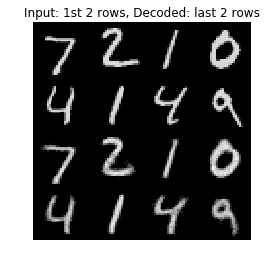

In [3]:
import tensorflow as tf
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
hidden_units = [32, 64]


inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
x = Dense(hidden_units[0], activation='relu')(x)
x = Dense(hidden_units[1], activation='relu')(x)

shape = K.int_shape(x)
print(shape,"----")

# generate latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs,
                latent,
                name='encoder')
encoder.summary()
plot_model(encoder,
           to_file='encoder.png',
           show_shapes=True)


latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
x = Dense(hidden_units[0], activation='relu')(x)
x = Dense(hidden_units[1], activation='relu')(x)

outputs = Dense(1, activation='relu')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='decoder.png', show_shapes=True)

autoencoder = Model(inputs,
                    decoder(encoder(inputs)),
                    name='autoencoder')
autoencoder.summary()
plot_model(autoencoder,
           to_file='autoencoder.png',
           show_shapes=True)

autoencoder.compile(loss='mse', optimizer='adam')


autoencoder.fit(x_train,
                x_train,
                validation_data=(x_test, x_test),
                epochs=1,
                batch_size=batch_size)

x_decoded = autoencoder.predict(x_test)

imgs = np.concatenate([x_test[:8], x_decoded[:8]])
imgs = imgs.reshape((4, 4, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Input: 1st 2 rows, Decoded: last 2 rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('input_and_decoded.png')
plt.show()

# REFERENCES

1. [Adavnced Keras Deep Learning Book](https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras)